In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

(100, 9)


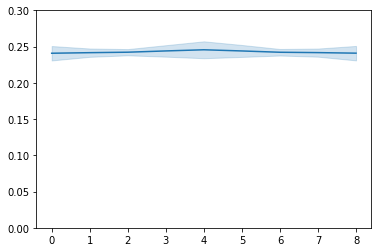

In [15]:
data = loadmat('mean_perm_resps.mat')['mean_resp_lst']
x_data = []
y_data = []
for i in range(data.shape[0]):
    y_data.extend(data[i])
    x_data.extend(np.arange(9))

sns.lineplot(np.array(x_data), np.array(y_data), ci="sd")
plt.ylim(0, 0.3)
print(data.shape)

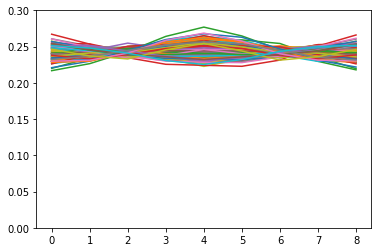

In [6]:
for i in range(data.shape[0]):
    plt.plot(data[i])

plt.ylim(0, 0.3)
plt.show()

In [90]:
data = loadmat("../Data/s08_EEG_ori_mini.mat")
trn = data["trn"]
trng = data["trng"].squeeze()
ts = data["ts"]

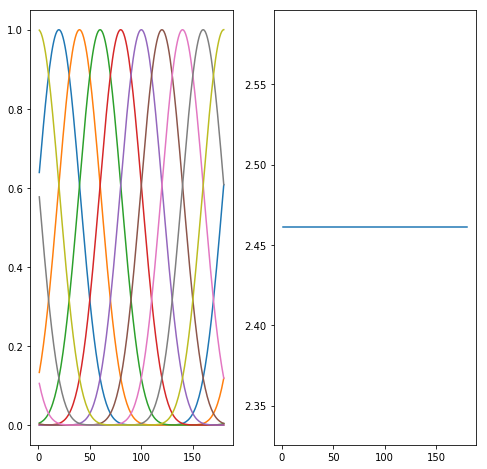

In [91]:
n_ori_chans = 9
make_basis_function = lambda xx, mu: np.power(np.cos(np.deg2rad(xx - mu)), n_ori_chans - (n_ori_chans % 2))

xx = np.linspace(1, 180, 180)
basis_set = np.zeros((180, n_ori_chans))
chan_center = np.linspace(180 / n_ori_chans, 180, n_ori_chans)
#chan_center = np.linspace(0, 180 - 180 / n_ori_chans, n_ori_chans)

for cc in range(n_ori_chans):
    basis_set[:, cc] = make_basis_function(xx, chan_center[cc])

fig = plt.figure(figsize=(8,8))
ax0 = fig.add_subplot(1, 2, 1)
ax0.plot(xx, basis_set)

ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(xx, np.sum(basis_set, 1))

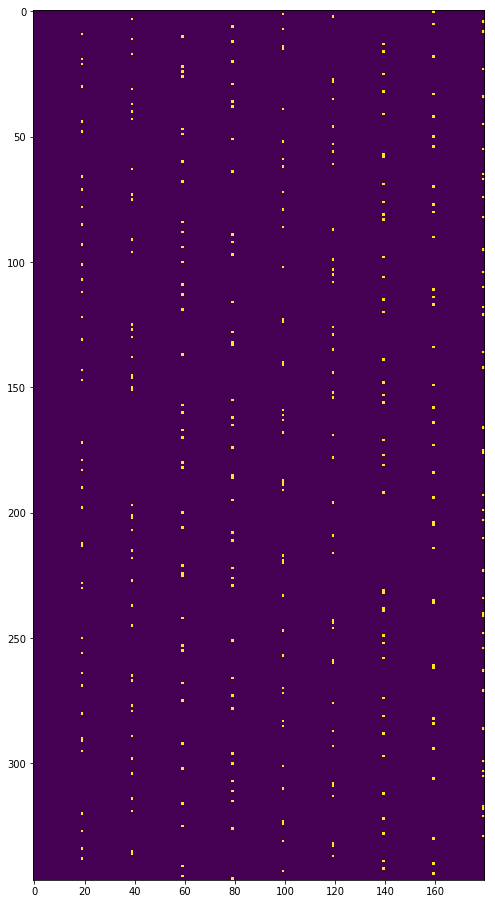

In [92]:
trng = trng % 180
trng[trng == 0] = 180
stim_mask = np.zeros((len(trng), len(xx)))

for tt in range(stim_mask.shape[0]):
    stim_mask[tt, trng[tt]-1] = 1
    #stim_mask[tt, trng[tt]] = 1

figure = plt.figure(figsize=(16,16))
plt.imshow(stim_mask)

9


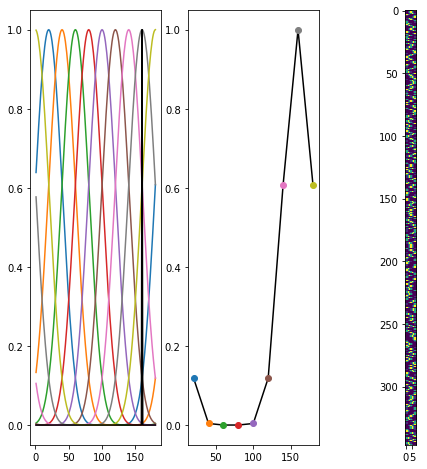

In [93]:
trnX = stim_mask @ basis_set
print(np.linalg.matrix_rank(trnX))

tr_num = 5
fig = plt.figure(figsize=(8,8))
ax0 = fig.add_subplot(1, 3, 1)
ax0.plot(xx, basis_set)
ax0.plot(xx, stim_mask[tr_num, :], 'k-')

ax1 = fig.add_subplot(1, 3, 2)
plt.plot(chan_center, trnX[tr_num, :], 'k-')
for cc in range(n_ori_chans):
    ax1.plot(chan_center[cc], trnX[tr_num, cc], 'o')

ax2 = fig.add_subplot(1, 3, 3)
plt.imshow(trnX)

In [104]:
trn_ou = np.unique(trng)
trn_repnum = np.zeros(len(trng))
trn_repnum[:] = np.nan
n_trials_per_orientation = np.zeros(len(trn_ou))

for ii in range(len(trn_ou)):
    n_trials_per_orientation[ii] = len(trn_repnum[trng == trn_ou[ii]])
    trn_repnum[trng == trn_ou[ii]] = np.arange(n_trials_per_orientation[ii])

trn_repnum[trn_repnum >= np.min(n_trials_per_orientation)] = np.nan
trng_cv = trng[~np.isnan(trn_repnum)]
trn_cv = trn[~np.isnan(trn_repnum)]

trn_cv_coeffs = np.zeros((len(trng_cv), 2 * trn.shape[1], trn.shape[2]))
trn_cv_coeffs[:, :trn.shape[1], :] = np.real(trn_cv)
trn_cv_coeffs[:, trn.shape[1]:, :] = np.imag(trn_cv)
trnX_cv = trnX[~np.isnan(trn_repnum)]
trn_repnum = trn_repnum[~np.isnan(trn_repnum)]

chan_resp_cv_coeffs = np.zeros((trn_cv_coeffs.shape[0], len(chan_center), trn_cv_coeffs.shape[2]))

n_reps = int(np.max(trn_repnum))

for ii in range(n_reps):
    trnidx = trn_repnum != ii
    tstidx = trn_repnum == ii

    thistrn = trn_cv_coeffs[trnidx, :, :]
    thistst = trn_cv_coeffs[tstidx, :, :]

    for tt in range(thistrn.shape[2]):
        thistrn_tpt = thistrn[:, :, tt]
        thistst_tpt = thistst[:, :, tt]

        w_coeffs = np.linalg.lstsq(trnX_cv[trnidx, :], thistrn_tpt)[0]

        chan_resp_cv_coeffs[tstidx, :, tt] = np.linalg.lstsq(w_coeffs.T, thistst_tpt.T)[0].T

C:\Users\henbo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\henbo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:37: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


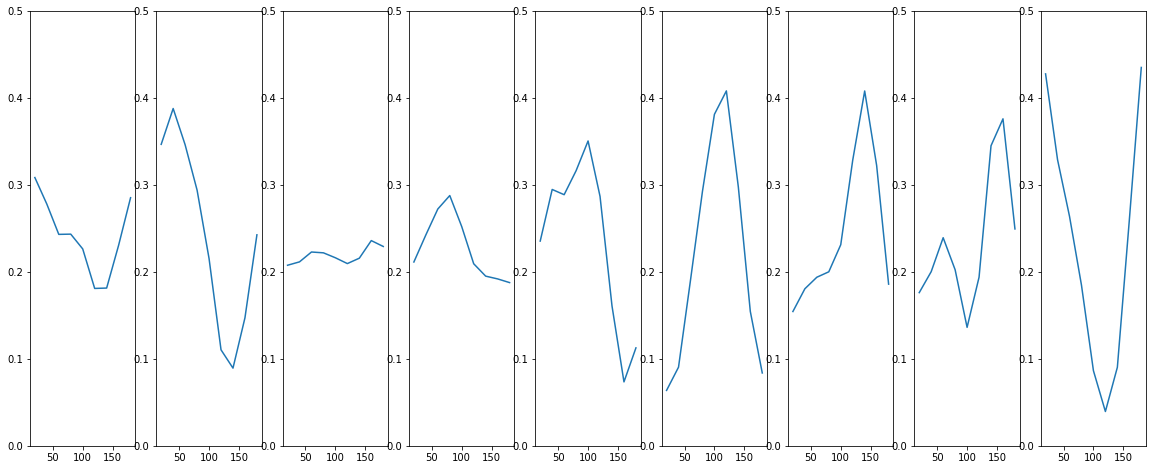

In [105]:
trange = [0.0, 0.4]
tmean = np.mean(chan_resp_cv_coeffs[:, :, 32:-32], axis=2)

fig = plt.figure(figsize=(20,8))
for ii in range(len(trn_ou)):
    ax = fig.add_subplot(1, len(trn_ou), ii+1)
    thisidx = trng_cv == trn_ou[ii]
    ax.set_ylim([0, 0.5])

    ax.plot(chan_center, np.mean(tmean[thisidx, :], axis=0))

4


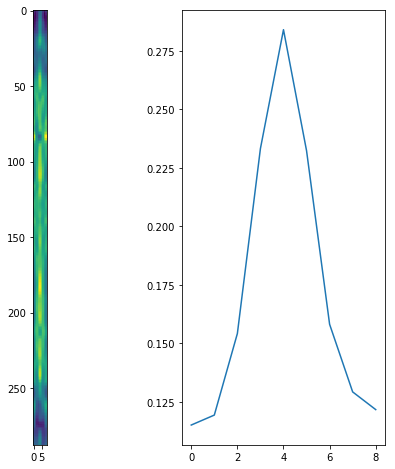

In [111]:
targ_ori = int(np.round(len(chan_center) / 2))
print(targ_ori)
chan_resp_cv_coeffs_shift = np.zeros(chan_resp_cv_coeffs.shape)

for ii in range(n_ori_chans):
    idx = trng_cv == trn_ou[ii]
    chan_resp_cv_coeffs_shift[idx, :, :] = np.roll(chan_resp_cv_coeffs[idx, :, :], targ_ori - ii, axis=1)

fig = plt.figure(figsize=(8, 8))
ax0 = fig.add_subplot(1, 2, 1)
ax0.imshow(np.mean(chan_resp_cv_coeffs_shift, 0).T)

ax1 = fig.add_subplot(1, 2, 2)
tmean = chan_resp_cv_coeffs_shift.mean(axis=2)
ax1 = plt.plot(tmean.mean(axis=0))